In [24]:
import numpy as np
import pandas as pd
import os
import cv2
import random
from tqdm import tqdm 


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report


import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.vgg16 import preprocess_input


TRAIN_DIR = '/kaggle/working/train/'  


TEST_DIR = '/kaggle/working/test1/' 


IMG_WIDTH = 224
IMG_HEIGHT = 224


N_SAMPLES = 4000

In [25]:
import zipfile
import os
from tqdm import tqdm


ZIP_TRAIN_PATH = '../input/dogs-vs-cats/train.zip'
ZIP_TEST_PATH = '../input/dogs-vs-cats/test1.zip'
OUTPUT_DIR = '/kaggle/working/'

print("Unzipping training data... (This may take a minute)")

with zipfile.ZipFile(ZIP_TRAIN_PATH, 'r') as zip_ref:
    
    for file in tqdm(iterable=zip_ref.infolist(), total=len(zip_ref.infolist())):
        zip_ref.extract(member=file, path=OUTPUT_DIR)

print("\nUnzipping test data...")
with zipfile.ZipFile(ZIP_TEST_PATH, 'r') as zip_ref:
    for file in tqdm(iterable=zip_ref.infolist(), total=len(zip_ref.infolist())):
        zip_ref.extract(member=file, path=OUTPUT_DIR)
        
print("\nUnzipping complete.")
print(f"Files are extracted to {OUTPUT_DIR}")


print("\nContents of /kaggle/working/:")
print(os.listdir(OUTPUT_DIR))

Unzipping training data... (This may take a minute)


100%|██████████| 25001/25001 [00:06<00:00, 4114.64it/s]



Unzipping test data...


100%|██████████| 12501/12501 [00:03<00:00, 4090.58it/s]


Unzipping complete.
Files are extracted to /kaggle/working/

Contents of /kaggle/working/:
['.virtual_documents', 'test1', 'submission.csv', 'train']


In [27]:

all_train_files = os.listdir(TRAIN_DIR)


all_train_files = [f for f in all_train_files if f.endswith('.jpg')]


all_train_paths = [os.path.join(TRAIN_DIR, f) for f in all_train_files]


random.seed(42) 
random.shuffle(all_train_paths)
image_paths = all_train_paths[:N_SAMPLES]


labels = []
for path in image_paths:
    filename = os.path.basename(path)
    if filename.startswith('cat'):
        labels.append(0)
    else:
        labels.append(1)


labels = np.array(labels)

print(f"Loaded {len(image_paths)} image paths.")
print(f"Created {len(labels)} labels.")
print(f"Class balance: {np.bincount(labels)} (0=Cat, 1=Dog)")

Loaded 4000 image paths.
Created 4000 labels.
Class balance: [2012 1988] (0=Cat, 1=Dog)


In [28]:

base_model = VGG16(weights='imagenet', 
                   include_top=False, 
                   input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
                   pooling='avg')


base_model.trainable = False

print("VGG16 Base Model Loaded.")
base_model.summary()

VGG16 Base Model Loaded.


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [29]:
def extract_features(image_paths, model):
    """
    Loads images, preprocesses them for VGG16,
    and extracts features using the provided model.
    """
    features = []
    
    for path in tqdm(image_paths): 
        img = load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT))
        
        
        img_array = img_to_array(img)
        
        
        img_array_expanded = np.expand_dims(img_array, axis=0)
        
        
        img_preprocessed = preprocess_input(img_array_expanded)
        
       
        feature = model.predict(img_preprocessed, verbose=0)
        features.append(feature.flatten())
        
    return np.array(features)


print(f"Extracting features from {len(image_paths)} images...")
X_features = extract_features(image_paths, base_model)

print(f"Features shape: {X_features.shape}")
print(f"Labels shape: {labels.shape}")

Extracting features from 4000 images...


100%|██████████| 4000/4000 [06:08<00:00, 10.84it/s]

Features shape: (4000, 512)
Labels shape: (4000,)


In [30]:

X_train, X_val, y_train, y_val = train_test_split(X_features, labels, 
                                                  test_size=0.2, 
                                                  random_state=42,
                                                  stratify=labels) 

print(f"Training features shape: {X_train.shape}")
print(f"Validation features shape: {X_val.shape}")


print("\nScaling features...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val) 


print("Training the SVM...")
svm_model = SVC(kernel='linear', probability=True, C=1.0, random_state=42)
svm_model.fit(X_train_scaled, y_train)

print("Training complete.")

Training features shape: (3200, 512)
Validation features shape: (800, 512)

Scaling features...
Training the SVM...
Training complete.


In [31]:

y_pred = svm_model.predict(X_val_scaled)


accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=['Cat (0)', 'Dog (1)']))

Validation Accuracy: 96.38%

Classification Report:
              precision    recall  f1-score   support

     Cat (0)       0.96      0.97      0.96       402
     Dog (1)       0.97      0.96      0.96       398

    accuracy                           0.96       800
   macro avg       0.96      0.96      0.96       800
weighted avg       0.96      0.96      0.96       800



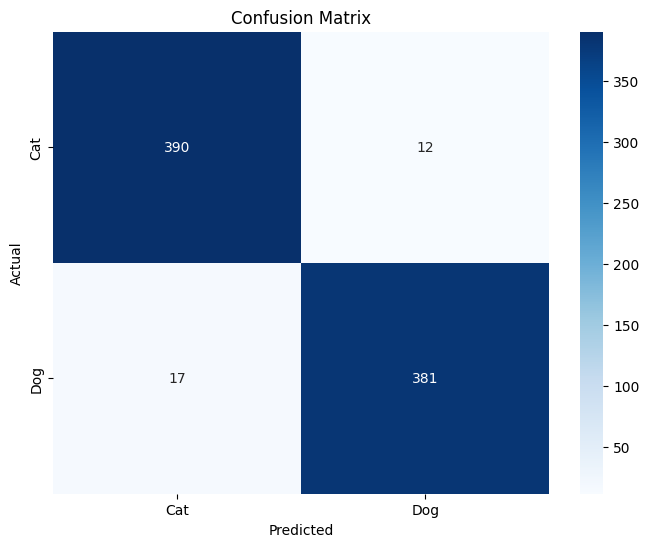

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_val, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Cat', 'Dog'], 
            yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [35]:

test_files = os.listdir(TEST_DIR)
test_files = [f for f in test_files if f.endswith('.jpg')]
test_paths = [os.path.join(TEST_DIR, f) for f in test_files]


test_ids = [int(os.path.basename(p).split('.')[0]) for p in test_paths]


sorted_lists = sorted(zip(test_ids, test_paths))
test_ids_sorted, test_paths_sorted = zip(*sorted_lists)

print(f"Found and sorted {len(test_paths_sorted)} test images.")

Found and sorted 12500 test images.


In [36]:
X_test_features = extract_features(test_paths_sorted, base_model)

print(f"Test features shape: {X_test_features.shape}")
print("Test feature extraction complete.")

100%|██████████| 12500/12500 [19:20<00:00, 10.77it/s]

Test features shape: (12500, 512)
Test feature extraction complete.


In [37]:
X_test_scaled = scaler.transform(X_test_features)

predictions = svm_model.predict_proba(X_test_scaled)[:, 1]

print("Predictions complete.")

Predictions complete.


In [38]:

submission_df = pd.DataFrame({
    'id': test_ids_sorted,
    'label': predictions
})


submission_df['label'] = np.clip(submission_df['label'], 0.005, 0.995)


submission_df.to_csv('submission.csv', index=False)

print("\nsubmission.csv file created successfully!")
print("Here's a preview of your submission file:")
submission_df.head()


submission.csv file created successfully!
Here's a preview of your submission file:


,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
